# Homework 3 CSCI 4364/6364 Machine Learning

##**A Tour of Multivariate Classification**

**Due Date: 11/10/2022, 23:59 ET**

---

**Purpose:**
This homework will provide you with hands-on experience with some of the multivariate classification algorithms we discussed in class and expose you to one of the most cited datasets, MNIST.

You should get a broad appreciation for the various approaches to classification that will help you evaluate which approach is best for your real world research or industry application.

The [MNIST](http://yann.lecun.com/exdb/mnist/) database of handwritten digits has a training set of 60,000 examples, and a test set of 10,000 examples. It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. MNIST is a good dataset for this assignment, since it has 10 classes (0 - 9) with a large number of features.


---
**Submission Instructions:**
This assignment will be done entirely in this Colaboratory notebook, and you will submit your notebook via GWU blackboard. Please embed your code in code blocks and add in comments into the text blocks. 

**Grading on the notebook:**
This notebook is worth up to 5% (with up to 3% additional extra credit) of the semester grade, where 3% is completion and full functionality, and 2% is based on comments and descriptions, and well-written and commented Python code, based on the coding standards. The notebook should be fully explained and work in its entirety when you submit it.

**Coding Standards:**
Throughout this course, we will use [Google’s Python Style Guide](https://google.github.io/styleguide/pyguide.html) as the coding standard for homework and project submission. A big part of machine learning in industry is applying good programming practices.


**Name:** Anulekha Boddu

**GW ID:** G40397446

In [21]:
#@title Imports
##########################################################
# Always include all imports at the first executable cell.
##########################################################
from sklearn.datasets import fetch_openml
from keras.utils.np_utils import to_categorical
import numpy as np
import time
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod # Abstract Base Classes for Python
import matplotlib.image as mpimg
import seaborn as sns; sns.set()
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from typing import Dict, Optional
import tensorflow as tf
from gc import callbacks
import plotly.express as px
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow import keras
from tensorflow.keras import losses
from keras.callbacks import EarlyStopping

First, download the MNIST data using the code provided below.

Here are the first 9 digits of the MNIST data with label.


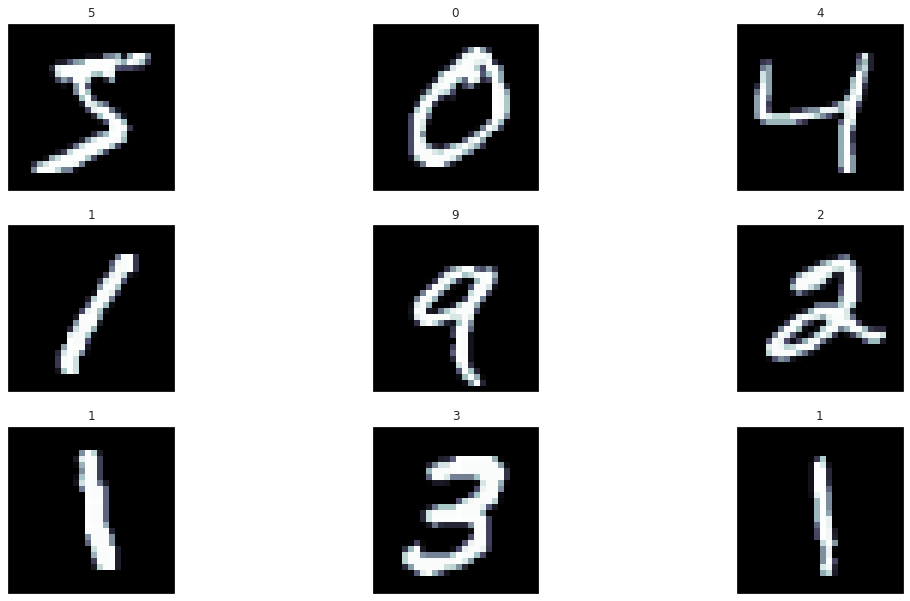

In [2]:
#@title Download MNIST, split, and plot example 
def plot_example(x_raw, y_raw):
  fig, axes = plt.subplots(3, 3)
  i = 0
  for i in range(3):
    for j in range(3):
      imgplot = axes[i,j].imshow(x_raw[i*3 + j].reshape((28,28)), cmap = 'bone')
      axes[i,j].set_title(y_raw[i*3 + j])
      axes[i,j].get_yaxis().set_visible(False)
      axes[i,j].get_xaxis().set_visible(False)
  fig.set_size_inches(18.5, 10.5, forward=True)


x_raw, y_raw = fetch_openml('mnist_784', version=1, return_X_y=True)
x = (x_raw/255).astype('float32').to_numpy()

# Split the data set into train, validation, and test sets.
x_trainval, x_test, y_trainval, y_test = train_test_split(x, y_raw, test_size=0.10, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_trainval, y_trainval, test_size=0.10, random_state=42)
print('Here are the first 9 digits of the MNIST data with label.')
plot_example(x, y_raw)

As in the past assignments, we'll define our base learning algorithm class, and create multiple implementations. Here, in the fit (or train) method, along with x_train and y_train, we'll include x_val, and y_val, as validation sets. Not all implementations will use them. 

In [3]:
#@title Define a base class class for Learning Algorithm

class BaseLearningAlgorithm(ABC):
  """Base class for a Supervised Learning Algorithm."""

  @abstractmethod
  def fit(self, x_train:np.array, y_train: np.array
          , x_val:np.array
          , y_val:np.array) -> None:
    """Trains a model from labels y and examples X.
    We include validation set for optional hyperparameter tuning. Not 
    all of the algorithims we use will    
    """

  @abstractmethod
  def predict(self, x_test: np.array) -> np.array:
    """Predicts on an unlabeled sample, X."""

  @property
  @abstractmethod
  def name(self) -> str:
    """Returns the name of the algorithm."""

Next, we want to establish a common approach to evaluating our implementations of `BaseLearningAlgorithm`.

A **Confusion Matrix** is a data table that helps visualize the performance of a multi-class classifier. The rows represent the true class assignmants from the test set labels, and the columns represent the predicted classes generated by the classifier. A perfect classifier will only populate the diagonal with counts and all off-diagonal elements of the matrix will be zero. Off-diagonal counts indiate that the model confuses the class in row $i$ with the class in column $j$. For example, in MNIST, the number $9$ might be confused $4$, and the associated cell at $i, j$ will be greater than $0$.

Besides precision and accuracy, the **F1-Score** is often used.  Review this [Wikipedia article](https://en.wikipedia.org/wiki/F-score) on F-Score.

##Question 1.
The Wikipedia article indicates that one weakness of the F-Score is that it assigns equal importance to precision and recall. Describe two scenarios where (a) precision may be more important to recall, and (b) where recall may be more important than precision.

(a) Precision is important when false positives have a cost. You want to make sure that all your true positives are truly positive. One example is pregnancy tests. News of a pregnancy can be detrimental to people's lives whereas a false negative result will simply delay news of pregnancy. 

(b) Recall is important when you want to make sure that the true negatives are truly negative. This is important when diagnosing patients with severe diseases, such as cancer. If the doctor is unable to identify an existing disease and dismisses the patient, it can cost them their life. 

In [4]:
#@title Define a basic train and evaluation pipeline

def train_eval(learning_algo: BaseLearningAlgorithm, x_train, y_train,x_val, y_val, x_test, y_test):
  """Trains and evaluates the generic model."""
  learning_algo.fit(x_train, y_train, x_val, y_val)
  y_pred = learning_algo.predict(x_test)
  mat = confusion_matrix(y_test, y_pred)
  sns.set(rc = {'figure.figsize':(8,8)})
  sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
              xticklabels=['%d' %i for i in range(10)],
              yticklabels=['%d' %i for i in range(10)])
  plt.xlabel('true label')
  plt.ylabel('predicted label')
  plt.title(learning_algo.name)
  
  print(classification_report(y_test, y_pred,
                              target_names=['%d' %i for i in range(10)]))

#1. Linear model with Logistic Regression
Let's start with basic logistic regression and demonstrate that Logistic Regression works on a multiclass classification problem.

We'll use the familiar least squares regression model with L2 regularization as a baseline for comparison. 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  5.2min finished


              precision    recall  f1-score   support

           0       0.97      0.97      0.97       683
           1       0.94      0.97      0.96       800
           2       0.90      0.89      0.90       674
           3       0.89      0.89      0.89       760
           4       0.92      0.93      0.92       611
           5       0.89      0.88      0.89       658
           6       0.94      0.95      0.94       677
           7       0.93      0.94      0.93       724
           8       0.90      0.86      0.88       693
           9       0.92      0.90      0.91       720

    accuracy                           0.92      7000
   macro avg       0.92      0.92      0.92      7000
weighted avg       0.92      0.92      0.92      7000

CPU times: user 8min 41s, sys: 58.2 s, total: 9min 39s
Wall time: 5min 14s


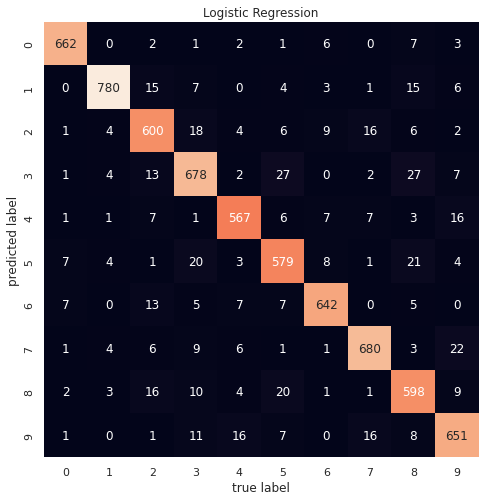

In [5]:
#@title Define the basic Logistic Regression Model

class LogisticRegressionLearningAlgorithm(BaseLearningAlgorithm):
  """Minimalist wrapper class for basic Logistic Regression."""

  def __init__(self, max_iters: int = 1000):
    self._model = LogisticRegression(max_iter = max_iters, verbose = True, penalty = 'l2')

  def fit(self, x_train:np.array, y_train: np.array, x_val:np.array, y_val: np.array) -> None:
    self._model.fit(x_train,y_train)
    # Don't need the validation data in Logistic Regression

  def predict(self, x_test: np.array) -> np.array:
    return self._model.predict(x_test)

  @property
  def name(self) -> str:
    return 'Logistic Regression'

learning_algo = LogisticRegressionLearningAlgorithm(max_iters = 1000)
%time train_eval(learning_algo, x_train, y_train, x_val, y_val, x_test, y_test)

#2. Support Vector Machine + Principal Components Analysis
In this section, we'll investigate the Support Vector Machine with and without dimensionality reduction using PCA. 

##2.1 Basic SVM (Task 1)
In the block below, use Scikit-Learn's SVM classifier, SVC. Configure the SVC with a Radial Basis Function Kernel (RBF), and parameterize the cost value and the RBF gamma parameter.

              precision    recall  f1-score   support

           0       0.97      0.98      0.98       683
           1       0.94      0.98      0.96       800
           2       0.92      0.92      0.92       674
           3       0.91      0.90      0.90       760
           4       0.89      0.94      0.92       611
           5       0.90      0.90      0.90       658
           6       0.95      0.96      0.96       677
           7       0.95      0.94      0.95       724
           8       0.94      0.88      0.91       693
           9       0.93      0.91      0.92       720

    accuracy                           0.93      7000
   macro avg       0.93      0.93      0.93      7000
weighted avg       0.93      0.93      0.93      7000

CPU times: user 8min 45s, sys: 904 ms, total: 8min 46s
Wall time: 8min 44s


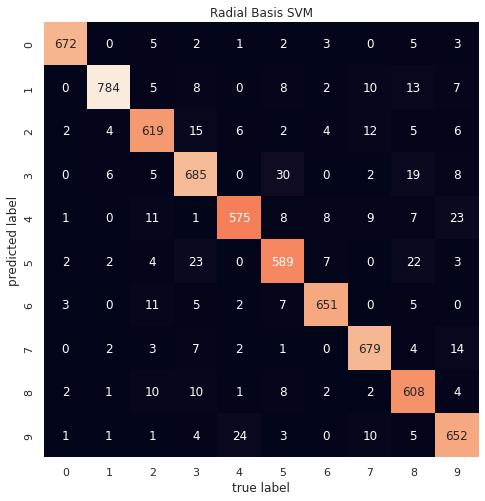

In [6]:
class RadialBasisSvmLearningAlgorithm(BaseLearningAlgorithm):
  """RBF SVM Classifier function."""

  def __init__(self, cost: float, gamma: float):
    # raise NotImplementedError('Please implement me!')
    self._model = SVC(C=cost, gamma = gamma)

  def fit(self, x_train:np.array, y_train: np.array, x_val:np.array, y_val: np.array) -> None:
    # raise NotImplementedError('Please implement me!')
    self._model.fit(x_train, y_train)

  def predict(self, x_test: np.array) -> np.array:
    # raise NotImplementedError('Please implement me!')
    return self._model.predict(x_test)
    
  @property
  def name(self) -> str:
    return 'Radial Basis SVM'

learning_algo = RadialBasisSvmLearningAlgorithm(cost = 10.0, gamma = 0.0001)
%time train_eval(learning_algo, x_train, y_train, x_val, y_val, x_test, y_test)

##2.2 Dimensionality Reduction with PCA (Task 2)

Next, we'll use PCA to reduce the input space from 784 dimensions to lower dimensions with lower variance. But how how many dimensions do we choose to keep? To help deceide that, we should first plot out the explained varaince by the number of singular values. This gives us picture of how much information is lost by removing the smallest singular values.  

In the code below, use Scikit-Learn's PCA class with `x_train` and plot out the explained variance ratio against the number of components (singular values).  

In [7]:
#@title Fit PCA and plot the explained variance as a function of components

pca = PCA()
X_pca = pca.fit(x_train)

explained_variance = pca.explained_variance_ratio_
print(explained_variance)

[9.72304568e-02 7.16803372e-02 6.14880286e-02 5.42720631e-02
 4.88742255e-02 4.31577787e-02 3.27019803e-02 2.88137123e-02
 2.76255831e-02 2.33503822e-02 2.11828481e-02 2.03474239e-02
 1.71237830e-02 1.69438720e-02 1.58570129e-02 1.47657143e-02
 1.31651144e-02 1.27050439e-02 1.19083654e-02 1.15275383e-02
 1.07015232e-02 1.00946100e-02 9.53340810e-03 9.10574757e-03
 8.85085296e-03 8.37885961e-03 8.11146200e-03 7.83561077e-03
 7.39895366e-03 6.92478055e-03 6.56171655e-03 6.47466863e-03
 6.00326201e-03 5.86079899e-03 5.67940436e-03 5.44542819e-03
 5.06645534e-03 4.86510480e-03 4.78766439e-03 4.67000948e-03
 4.53111529e-03 4.46564192e-03 4.18774365e-03 3.95847624e-03
 3.83223826e-03 3.76417558e-03 3.60593200e-03 3.49877588e-03
 3.39454901e-03 3.19938199e-03 3.16378474e-03 3.08432314e-03
 2.95475964e-03 2.88238120e-03 2.83134845e-03 2.69642426e-03
 2.66561890e-03 2.56197806e-03 2.52713147e-03 2.44698348e-03
 2.39833049e-03 2.37932382e-03 2.30020587e-03 2.20657047e-03
 2.12521898e-03 2.052424

In [8]:
px.area(
    x=range(1, explained_variance.shape[0] + 1),
    y=explained_variance,
    labels={"x": "# Components", "y": "Explained Variance"}
)

Text(0, 0.5, 'Cumulative Explained Variance')

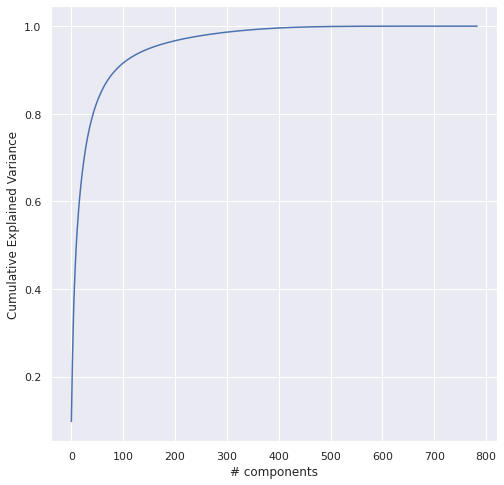

In [9]:
pca = PCA().fit(x_train)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("# components")
plt.ylabel("Cumulative Explained Variance")


##Question 2. 
Based on the variance vs. num components chart above, how many components represent 80% and 90% of the explained variance?



##2.2 Apply PCA to reduce dimensionality for SVM (Task 3)

In the code block below, extend the basic SVM class from 2.1 and name it `RadialBasisSvmPcaLearningAlgorithm` that first reduces the dimension. You can use Scikit-Learn's `make_pipeline()` method to combine PCA and SVC into a pipeline.

              precision    recall  f1-score   support

           0       0.96      0.97      0.96       683
           1       0.92      0.98      0.95       800
           2       0.90      0.89      0.90       674
           3       0.89      0.86      0.88       760
           4       0.89      0.93      0.91       611
           5       0.86      0.88      0.87       658
           6       0.93      0.95      0.94       677
           7       0.94      0.93      0.93       724
           8       0.91      0.84      0.87       693
           9       0.91      0.88      0.89       720

    accuracy                           0.91      7000
   macro avg       0.91      0.91      0.91      7000
weighted avg       0.91      0.91      0.91      7000

CPU times: user 1min 37s, sys: 918 ms, total: 1min 38s
Wall time: 1min 36s


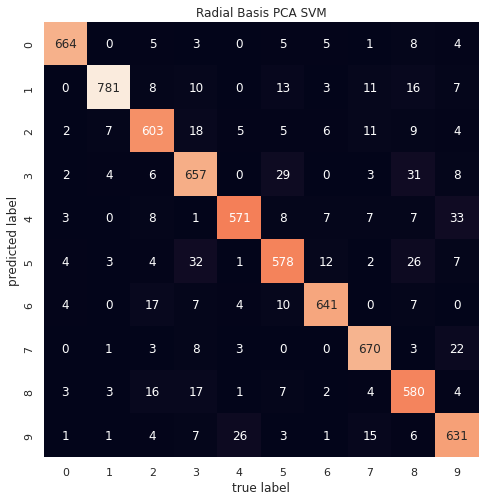

In [10]:
class RadialBasisSvmPcaLearningAlgorithm(BaseLearningAlgorithm):
  """RBF SVM Classifier function."""

  def __init__(self, num_pca_components: float, tcost: float, gamma: float):
    # raise NotImplementedError('Please implement me!')
    self._model = make_pipeline(PCA(n_components = num_pca_components), SVC(C= tcost, gamma = gamma))

  def fit(self, x_train:np.array, y_train: np.array, x_val:np.array, y_val: np.array) -> None:
    # raise NotImplementedError('Please implement me!')
    self._model.fit(x_train, y_train)

  def predict(self, x_test: np.array) -> np.array:
    # raise NotImplementedError('Please implement me!')
    return self._model.predict(x_test)
    
  @property
  def name(self) -> str:
    return 'Radial Basis PCA SVM'

learning_algo = RadialBasisSvmPcaLearningAlgorithm(num_pca_components=30, tcost = 10.0, gamma = 0.0001)
%time train_eval(learning_algo, x_train, y_train, x_val, y_val, x_test, y_test)


              precision    recall  f1-score   support

           0       0.97      0.98      0.98       683
           1       0.93      0.98      0.96       800
           2       0.91      0.91      0.91       674
           3       0.91      0.89      0.90       760
           4       0.90      0.94      0.92       611
           5       0.89      0.89      0.89       658
           6       0.94      0.96      0.95       677
           7       0.96      0.94      0.95       724
           8       0.93      0.87      0.90       693
           9       0.92      0.90      0.91       720

    accuracy                           0.93      7000
   macro avg       0.93      0.93      0.93      7000
weighted avg       0.93      0.93      0.93      7000

CPU times: user 2min 22s, sys: 1.04 s, total: 2min 23s
Wall time: 2min 25s


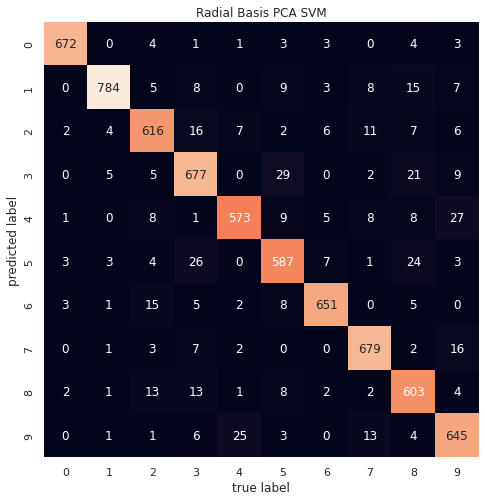

In [13]:
learning_algo = RadialBasisSvmPcaLearningAlgorithm(num_pca_components=70, tcost = 10.0, gamma = 0.0001)
%time train_eval(learning_algo, x_train, y_train, x_val, y_val, x_test, y_test)

              precision    recall  f1-score   support

           0       0.97      0.98      0.98       683
           1       0.94      0.98      0.96       800
           2       0.92      0.92      0.92       674
           3       0.91      0.90      0.90       760
           4       0.89      0.94      0.92       611
           5       0.90      0.90      0.90       658
           6       0.95      0.96      0.96       677
           7       0.95      0.94      0.95       724
           8       0.94      0.88      0.91       693
           9       0.93      0.91      0.92       720

    accuracy                           0.93      7000
   macro avg       0.93      0.93      0.93      7000
weighted avg       0.93      0.93      0.93      7000

CPU times: user 7min 30s, sys: 3.65 s, total: 7min 33s
Wall time: 7min 22s


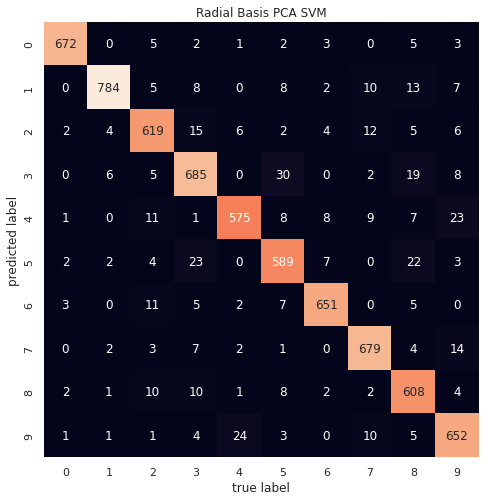

In [12]:
learning_algo = RadialBasisSvmPcaLearningAlgorithm(num_pca_components=60, tcost = 10.0, gamma = 0.0001)
%time train_eval(learning_algo, x_train, y_train, x_val, y_val, x_test, y_test)

##Question 3.
What is the minimum number of components required to achieve equivalent performance to basic SVM without PCA (2.1)?

Since the accuracy with 60 components is 0.92 and 0.93 with 70, the minimum number of components would be somewhere between 60 and 70.

#3. Random Forest

In this section, we'll investigate the Random Forest algorithm that aggregates its answer using many decorrelated trees. 

##3.1 Tuning the Random Forest (Task 4)
In the code black below, write an extension class to `BaseLearningAlgorithm` called `RandomForestLearningAlgorithm` using Scikit-Learn's RandomForestClassifier. You should parameterize the class with the number of estimators (i.e., number of trees), type of split (gini or entropy), max tree depth, minimum number of samples per node.

Without doing a formal hyperparameter tuning, like grid search, try a few variations to improve overall accuracy.

              precision    recall  f1-score   support

           0       0.92      0.96      0.94       683
           1       0.82      0.97      0.89       800
           2       0.89      0.86      0.87       674
           3       0.82      0.86      0.84       760
           4       0.87      0.83      0.85       611
           5       0.94      0.69      0.79       658
           6       0.89      0.93      0.91       677
           7       0.88      0.90      0.89       724
           8       0.88      0.75      0.81       693
           9       0.77      0.85      0.81       720

    accuracy                           0.86      7000
   macro avg       0.87      0.86      0.86      7000
weighted avg       0.87      0.86      0.86      7000

CPU times: user 15.5 s, sys: 52.7 ms, total: 15.6 s
Wall time: 15.8 s


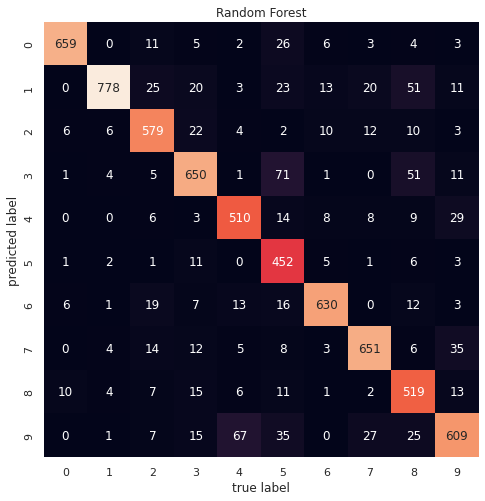

In [14]:
class RandomForestLearningAlgorithm(BaseLearningAlgorithm):
  """Random Forest Classifier function."""

  def __init__(self, n_estimators: float, criterion: str, max_depth: float, min_samples_split: float):
    # raise NotImplementedError('Please implement me!')
    self._model = RandomForestClassifier(n_estimators = n_estimators, criterion = criterion, max_depth = max_depth, min_samples_split = min_samples_split)

  def fit(self, x_train:np.array, y_train: np.array, x_val:np.array, y_val: np.array) -> None:
    # raise NotImplementedError('Please implement me!')
    self._model.fit(x_train, y_train)

  def predict(self, x_test: np.array) -> np.array:
    # raise NotImplementedError('Please implement me!')
    return self._model.predict(x_test)
    
  @property
  def name(self) -> str:
    return 'Random Forest'

learning_algo = RandomForestLearningAlgorithm(n_estimators = 100, criterion = 'gini', max_depth = 5, min_samples_split = 2)
%time train_eval(learning_algo, x_train, y_train, x_val, y_val, x_test, y_test)

##Question 4.
What are the top three pairs of confusion (i.e., true row $i$, predicted column $j$), and are they the same as SVM? Why are these classes confused with each other?

The top three pairs of confusion for Random Forest:

1. (5, 3)

2. (4, 9)

3. (8, 1) and (8, 3)

The top three pairs for SVM with PCA:

1. (9, 4)

2. (3, 5)

3. (8, 3)

Both models have the same three pairs. The confusion might arise from the two numbers having similar shapes when written. For example both 3 and 5 have a curved bottom. 

#4. Feedforward Neural Networks

In this section, we'll explore feedforward neural networks. First, we'll make some enhancements to a NN written using just numpy to give you a sense for how forward and back-propagation work, and how the weights are optimized using basic gradient descent. 



##4.1 Neural network without libraries (Task 5)
Study the complete neural network implementation below. The architecture has an input width of 784 nodes, two hidden layers, and a softmax output layer of with 10 nodes (0-9).
Pay attention to the gradient calculation and the overall backpropagation algorithm, and how gradient descent adjusts the weights. Implement the ReLU activation funtion in the skeleton method provided below and compare the results to the sigmoid activation function.

Epoch: 1, Time Spent: 47.79s, Validation Accuracy: 26.83%
Epoch: 2, Time Spent: 98.21s, Validation Accuracy: 32.84%
Epoch: 3, Time Spent: 145.98s, Validation Accuracy: 35.71%
Epoch: 4, Time Spent: 199.42s, Validation Accuracy: 38.57%
Epoch: 5, Time Spent: 246.70s, Validation Accuracy: 42.76%
Epoch: 6, Time Spent: 295.17s, Validation Accuracy: 47.29%
Epoch: 7, Time Spent: 343.34s, Validation Accuracy: 50.62%
Epoch: 8, Time Spent: 392.61s, Validation Accuracy: 52.97%
Epoch: 9, Time Spent: 440.14s, Validation Accuracy: 54.75%
Epoch: 10, Time Spent: 487.44s, Validation Accuracy: 56.76%


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



              precision    recall  f1-score   support

           0       0.56      0.95      0.70       683
           1       0.56      0.98      0.71       800
           2       0.56      0.81      0.66       674
           3       0.00      0.00      0.00       760
           4       0.49      0.85      0.62       611
           5       0.00      0.00      0.00       658
           6       0.71      0.88      0.79       677
           7       0.52      0.82      0.64       724
           8       0.56      0.32      0.41       693
           9       0.07      0.00      0.00       720

    accuracy                           0.56      7000
   macro avg       0.40      0.56      0.45      7000
weighted avg       0.40      0.56      0.45      7000

CPU times: user 8min 32s, sys: 7min 3s, total: 15min 36s
Wall time: 8min 8s


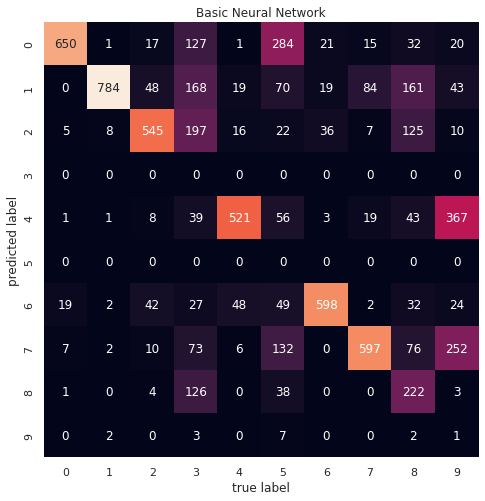

In [15]:
#@title Basic Neural Network Algorithm

class DeepNeuralNetworkLearningAlgorithm(BaseLearningAlgorithm):
    def __init__(self, sizes, epochs=10, l_rate=0.001):
        self.sizes = sizes
        self.epochs = epochs
        self.l_rate = l_rate

        # Save all parameters in the neural network in this dictionary
        self.params = self.initialization()

    def sigmoid(self, x, derivative=False):
        if derivative:
            return (np.exp(-x))/((np.exp(-x)+1)**2)
        return 1/(1 + np.exp(-x))

    def relu(self, x, derivative=False):
        if derivative:
            return np.where(x > 0, 1, 0)
        return np.where(x>0, x, 0) 

    def softmax(self, x, derivative=False):
        exps = np.exp(x - x.max())
        if derivative:
            return exps / np.sum(exps, axis=0) * (1 - exps / np.sum(exps, axis=0))
        return exps / np.sum(exps, axis=0)

    def initialization(self):
        # number of nodes in each layer
        input_layer=self.sizes[0]
        hidden_1=self.sizes[1]
        hidden_2=self.sizes[2]
        output_layer=self.sizes[3]

        params = {
            'W1':np.random.randn(hidden_1, input_layer) * np.sqrt(1. / hidden_1),
            'W2':np.random.randn(hidden_2, hidden_1) * np.sqrt(1. / hidden_2),
            'W3':np.random.randn(output_layer, hidden_2) * np.sqrt(1. / output_layer)
        }

        return params

    def forward_pass(self, x_train: np.array) -> np.array:
        params = self.params

        # input layer activations becomes sample
        params['A0'] = x_train

        # input layer to hidden layer 1
        params['Z1'] = np.dot(params["W1"], params['A0'])
        params['A1'] = self.sigmoid(params['Z1'])

        # hidden layer 1 to hidden layer 2
        params['Z2'] = np.dot(params["W2"], params['A1'])
        params['A2'] = self.sigmoid(params['Z2'])

        # hidden layer 2 to output layer
        params['Z3'] = np.dot(params["W3"], params['A2'])
        params['A3'] = self.softmax(params['Z3'])

        return params['A3']

    def backward_pass(self, y_train: np.array, output: np.array) -> Dict[str, np.array]:
        """Perfoms backpropagation."""
        params = self.params
        change_w = {}

        # Calculate W3 update
        error = 2 * (output - y_train) / output.shape[0] * self.softmax(params['Z3'], derivative=True)
        change_w['W3'] = np.outer(error, params['A2'])

        # Calculate W2 update
        error = np.dot(params['W3'].T, error) * self.sigmoid(params['Z2'], derivative=True)
        change_w['W2'] = np.outer(error, params['A1'])

        # Calculate W1 update
        error = np.dot(params['W2'].T, error) * self.sigmoid(params['Z1'], derivative=True)
        change_w['W1'] = np.outer(error, params['A0'])

        return change_w

    def update_network_parameters(self, changes_to_w: Dict[str, np.array]):
        """Updates network parameters according to update rule from
            Stochastic Gradient Descent.

            θ = θ - η * ∇J(x, y), 
                theta θ:            a network parameter (e.g. a weight w)
                eta η:              the learning rate
                gradient ∇J(x, y):  the gradient of the objective function,
                                    i.e. the change for a specific theta θ
        """
        
        for key, value in changes_to_w.items():
            self.params[key] -= self.l_rate * value

    def compute_accuracy(self, x_val, y_val):
        """
            This function does a forward pass of x, then checks if the indices
            of the maximum value in the output equals the indices in the label
            y. Then it sums over each prediction and calculates the accuracy.
        """
        predictions = []
        y_val = to_categorical(y_val)
        for x, y in zip(x_val, y_val):

            output = self.forward_pass(x)
            pred = np.argmax(output)
            predictions.append(pred == np.argmax(y))
        
        return np.mean(predictions)

    def predict(self, X_test: np.array) -> np.array: 
      """Predicts on a test set."""
      return np.array([str(np.argmax(self.forward_pass(x))) for x in X_test])

    def fit(self, x_train, y_train, x_val, y_val):
        y_train = to_categorical(y_train)
        start_time = time.time()
        for iteration in range(self.epochs):
            for x,y in zip(x_train, y_train):
                
                output = self.forward_pass(x)
              
                changes_to_w = self.backward_pass(y, output)
                self.update_network_parameters(changes_to_w)
                 
            accuracy = self.compute_accuracy(x_val, y_val)
            print('Epoch: {0}, Time Spent: {1:.2f}s, Validation Accuracy: {2:.2f}%'.format(
                iteration+1, time.time() - start_time, accuracy * 100
            ))
    @property
    def name(self) -> str:
      return 'Basic Neural Network'

learning_algo = DeepNeuralNetworkLearningAlgorithm(sizes=[784, 128, 64, 10], epochs=10, l_rate=0.001 )
%time train_eval(learning_algo, x_train, y_train, x_val, y_val, x_test, y_test)

Epoch: 1, Time Spent: 47.39s, Validation Accuracy: 71.92%
Epoch: 2, Time Spent: 93.10s, Validation Accuracy: 77.75%
Epoch: 3, Time Spent: 138.84s, Validation Accuracy: 80.08%
Epoch: 4, Time Spent: 184.40s, Validation Accuracy: 88.05%
Epoch: 5, Time Spent: 232.06s, Validation Accuracy: 89.29%
Epoch: 6, Time Spent: 277.94s, Validation Accuracy: 90.14%
Epoch: 7, Time Spent: 323.90s, Validation Accuracy: 90.76%
Epoch: 8, Time Spent: 370.07s, Validation Accuracy: 91.10%
Epoch: 9, Time Spent: 422.44s, Validation Accuracy: 91.51%
Epoch: 10, Time Spent: 468.27s, Validation Accuracy: 91.78%
              precision    recall  f1-score   support

           0       0.94      0.96      0.95       683
           1       0.95      0.97      0.96       800
           2       0.89      0.86      0.88       674
           3       0.88      0.89      0.89       760
           4       0.89      0.90      0.89       611
           5       0.91      0.89      0.90       658
           6       0.93      0.9

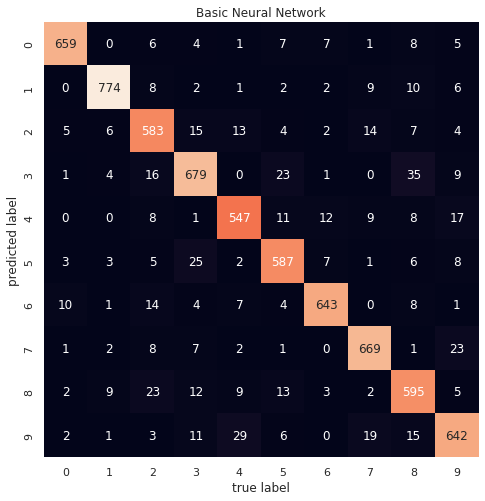

In [16]:
#@title Basic Neural Network Algorithm

class DeepNeuralNetworkLearningAlgorithm(BaseLearningAlgorithm):
    def __init__(self, sizes, epochs=10, l_rate=0.001):
        self.sizes = sizes
        self.epochs = epochs
        self.l_rate = l_rate

        # Save all parameters in the neural network in this dictionary
        self.params = self.initialization()

    def sigmoid(self, x, derivative=False):
        if derivative:
            return (np.exp(-x))/((np.exp(-x)+1)**2)
        return 1/(1 + np.exp(-x))

    def relu(self, x, derivative=False):
        if derivative:
            return np.where(x > 0, 1, 0)
        return np.where(x>0, x, 0) 

    def softmax(self, x, derivative=False):
        exps = np.exp(x - x.max())
        if derivative:
            return exps / np.sum(exps, axis=0) * (1 - exps / np.sum(exps, axis=0))
        return exps / np.sum(exps, axis=0)

    def initialization(self):
        # number of nodes in each layer
        input_layer=self.sizes[0]
        hidden_1=self.sizes[1]
        hidden_2=self.sizes[2]
        output_layer=self.sizes[3]

        params = {
            'W1':np.random.randn(hidden_1, input_layer) * np.sqrt(1. / hidden_1),
            'W2':np.random.randn(hidden_2, hidden_1) * np.sqrt(1. / hidden_2),
            'W3':np.random.randn(output_layer, hidden_2) * np.sqrt(1. / output_layer)
        }

        return params

    def forward_pass(self, x_train: np.array) -> np.array:
        params = self.params

        # input layer activations becomes sample
        params['A0'] = x_train

        # input layer to hidden layer 1
        params['Z1'] = np.dot(params["W1"], params['A0'])
        params['A1'] = self.relu(params['Z1'])

        # hidden layer 1 to hidden layer 2
        params['Z2'] = np.dot(params["W2"], params['A1'])
        params['A2'] = self.relu(params['Z2'])

        # hidden layer 2 to output layer
        params['Z3'] = np.dot(params["W3"], params['A2'])
        params['A3'] = self.softmax(params['Z3'])

        return params['A3']

    def backward_pass(self, y_train: np.array, output: np.array) -> Dict[str, np.array]:
        """Perfoms backpropagation."""
        params = self.params
        change_w = {}

        # Calculate W3 update
        error = 2 * (output - y_train) / output.shape[0] * self.softmax(params['Z3'], derivative=True)
        change_w['W3'] = np.outer(error, params['A2'])

        # Calculate W2 update
        error = np.dot(params['W3'].T, error) * self.relu(params['Z2'], derivative=True)
        change_w['W2'] = np.outer(error, params['A1'])

        # Calculate W1 update
        error = np.dot(params['W2'].T, error) * self.relu(params['Z1'], derivative=True)
        change_w['W1'] = np.outer(error, params['A0'])

        return change_w

    def update_network_parameters(self, changes_to_w: Dict[str, np.array]):
        """Updates network parameters according to update rule from
            Stochastic Gradient Descent.

            θ = θ - η * ∇J(x, y), 
                theta θ:            a network parameter (e.g. a weight w)
                eta η:              the learning rate
                gradient ∇J(x, y):  the gradient of the objective function,
                                    i.e. the change for a specific theta θ
        """
        
        for key, value in changes_to_w.items():
            self.params[key] -= self.l_rate * value

    def compute_accuracy(self, x_val, y_val):
        """
            This function does a forward pass of x, then checks if the indices
            of the maximum value in the output equals the indices in the label
            y. Then it sums over each prediction and calculates the accuracy.
        """
        predictions = []
        y_val = to_categorical(y_val)
        for x, y in zip(x_val, y_val):

            output = self.forward_pass(x)
            pred = np.argmax(output)
            predictions.append(pred == np.argmax(y))
        
        return np.mean(predictions)

    def predict(self, X_test: np.array) -> np.array: 
      """Predicts on a test set."""
      return np.array([str(np.argmax(self.forward_pass(x))) for x in X_test])

    def fit(self, x_train, y_train, x_val, y_val):
        y_train = to_categorical(y_train)
        start_time = time.time()
        for iteration in range(self.epochs):
            for x,y in zip(x_train, y_train):
                
                output = self.forward_pass(x)
              
                changes_to_w = self.backward_pass(y, output)
                self.update_network_parameters(changes_to_w)
                 
            accuracy = self.compute_accuracy(x_val, y_val)
            print('Epoch: {0}, Time Spent: {1:.2f}s, Validation Accuracy: {2:.2f}%'.format(
                iteration+1, time.time() - start_time, accuracy * 100
            ))
    @property
    def name(self) -> str:
      return 'Basic Neural Network'

learning_algo = DeepNeuralNetworkLearningAlgorithm(sizes=[784, 128, 64, 10], epochs=10, l_rate=0.001 )
%time train_eval(learning_algo, x_train, y_train, x_val, y_val, x_test, y_test)

##Question 5. 
When executing multiple times (using ReLU or sigmoid activations) for a fixed number of iterations, how much does the validation accuracy vary at the end of the training? What is causing the variation in performance?

Sigmoid had an accuracy 0.56. Relu Activation gave an accuracy of 0.91., so Relu performed better. The variation is caused by better Relu performancwe.

## Question 6.
Does the choice of activation function (ReLU vs. sigmoid) make any difference in validation accuracy?

Yes it does, since it performed better with Relu. 


##4.2 Feedforward Neural Network with Keras and Tensorflow (Task 6)
Next, set up and train a feedforward neural network in [Keras](https://keras.io/) and [Tensorflow](https://www.tensorflow.org/).



1.   Paramaterize your model with the number of hidden layers, epochs, learning rate, and activation function.
2.   Add **early stopping** and add a patience parameter. You can apply the [keras callback function](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping) to implement early stopping.
3.   Apply sparse categorical entropy loss function. 
4.   Apply Adaptive Moments (Adam) optimizer






In [17]:
#@title Define a basic train and evaluation pipeline

def train_eval_knn(learning_algo: BaseLearningAlgorithm, x_train, y_train,x_val, y_val, x_test, y_test):
  """Trains and evaluates the generic model."""
  learning_algo.fit(x_train, y_train, x_val, y_val)
 # y_pred = learning_algo.predict(x_test)
  y_pred = np.argmax(learning_algo.predict(x_test),axis=1)
  
  print(y_test.astype('float64').tolist())
  mat = confusion_matrix(y_test.astype('float64').tolist(), y_pred)
  sns.set(rc = {'figure.figsize':(8,8)})
  sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
              xticklabels=['%d' %i for i in range(10)],
              yticklabels=['%d' %i for i in range(10)])
  plt.xlabel('true label')
  plt.ylabel('predicted label')
  plt.title(learning_algo.name)
  y_test_char = np.array([str(v) for v in y_test.to_numpy()])

  return y_test, y_pred
  # print(type(y_pred))
  # print(classification_report(y_test_char, y_pred,
  #                             target_names=['%d' %i for i in range(10)]))

Epoch 1/3
1772/1772 [==============================] - 6s 3ms/step - loss: 0.2917 - accuracy: 0.9141
Epoch 2/3
1772/1772 [==============================] - 6s 3ms/step - loss: 0.1240 - accuracy: 0.9630
Epoch 3/3
219/219 [==============================] - 0s 2ms/step
[[-9.974754  -4.653149  -2.8148143 ... -7.4119306  8.985185  -4.454187 ]
 [-9.936989  -6.459893  -8.485149  ...  1.1274627 -8.291219  -3.565098 ]
 [-3.2357821 -2.0588098 -2.5015619 ... -3.7280102  4.38379   -1.410516 ]
 ...
 [-5.1585336 -3.8674223 -8.106937  ... -2.795833   0.829266  -4.5624585]
 [-2.6886573 -1.7264462  9.387578  ... -1.4802289 -3.7218394 -3.6764457]
 [-3.06303   -1.3805614 -4.704701  ... -3.6107197 -2.7618062 -7.3386874]]


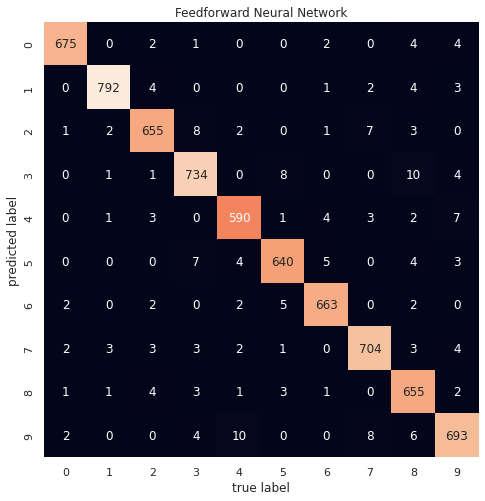

In [29]:
class KerasDnnLearningAlgorithm(BaseLearningAlgorithm):

  def __init__(self, hidden_layers, epochs, learning_rate, activation):
    self._model = Sequential()
    self.hidden_layers = hidden_layers
    self.epochs = epochs
    self.learning_rate = learning_rate
    self.activation = activation

  def fit(self, x_train, y_train, x_val, y_val):
    y_train = y_train.astype('int').to_numpy()
    y_val = y_val.astype('int').to_numpy()
    self._model.add(Dense(self.hidden_layers[0], input_dim=784, activation = self.activation))
    self._model.add(Dense(self.hidden_layers[1], activation = self.activation))
    self._model.add(Dropout(0.2))
    self._model.add(Dense(10))
    optimize = keras.optimizers.Adam(learning_rate = self.learning_rate)
    self._model.compile(optimizer=optimize, loss=losses.SparseCategoricalCrossentropy(from_logits = True), metrics =['accuracy'] )
    self._model.fit(x_train, y_train, epochs=self.epochs, callbacks= EarlyStopping(monitor='loss', patience=10, verbose= 1) )

  def predict(self,x_test:np.array) -> np.array:
    a = self._model.predict(x_test)
    return a
    
  @property
  def name(self) -> str:
    return 'Feedforward Neural Network' 

learning_algo = KerasDnnLearningAlgorithm(hidden_layers=[128, 64], epochs=1000, learning_rate=0.001, activation = 'relu' )
y_test, y_pred = train_eval_knn(learning_algo, x_train, y_train, x_val, y_val, x_test, y_test)

In [ ]:
y_test.to_numpy()

array(['8', '4', '8', ..., '5', '2', '6'], dtype=object)

In [25]:
y_pred_char = [str(y) for y in y_pred]

In [26]:
print(classification_report(y_test, y_pred_char,
                              target_names=['%d' %i for i in range(10)]))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       683
           1       0.99      0.99      0.99       800
           2       0.97      0.98      0.97       674
           3       0.97      0.97      0.97       760
           4       0.98      0.98      0.98       611
           5       0.98      0.97      0.98       658
           6       0.98      0.99      0.99       677
           7       0.97      0.98      0.98       724
           8       0.97      0.96      0.96       693
           9       0.97      0.97      0.97       720

    accuracy                           0.98      7000
   macro avg       0.98      0.98      0.98      7000
weighted avg       0.98      0.98      0.98      7000



##Question 6
Summarize the results of all your classifiers. Which classifiers performed better or worse than the logistic regression benchmark? Which method executed fastest in terms of time? Which was easiest to set up and parameterize? Which classes tended to get most often confused across all classifiers?

Linear = 0.92

Basic SVM = 0.93

SVM with PCA = 0.93

Random Forest = 0.86

Basic Neural Network = 0.91

FeedForward Neural Network = 0.98

The FeedForward Neural Network performed the best and Random Forest performed the worst. 

Basic SVM and Basic Neural Network took the longest. Random Forest was the fastest. 

The SVM with PCA was the easiest to set up due to the pipeline. 

The class that got most confused was the Basic Neural Network.

#Optional Extra Credit (max course credit: 3%)


*   Implement early stopping in 4.1 (**1% extra credit**). 
*   Add in one or more Keras dropout layers in 4.2 (**1% extra credit**).
*   Implement mini-batch gradient descent in 4.1, replacing stochastic gradient descent. Instead of making an update to a parameter for each sample, make an update based on the averaged value of each sample in a mini-batch. The size of the mini-batch is usually below 64. (**3% extra credit**)
*  Initialize biases and add them to Z in 4.1 before the activation function in the forward pass, and update the biases in the backward pass.  (**2% extra credit**)


